 <span>Spatio-temporal Metrics <img src="http://brazildatacube.org/wp-content/uploads/slider2/datacube-site.png" alt="Brazil Data Cube" style="height:200px;" align="right"></span>
===============================
---------------------------------------------------------------
    


In this notebook, we present some functionalities to perform Geographic Object Image Analysis (GEOBIA) with Earth Observation Data Cubes produced by the <strong>[Brazil Data Cube (BDC) project](http://brazildatacube.org/)</strong> using the <strong>[STMETRICS](https://readthedocs.org/projects/stmetrics/)</strong> package.


This notebook was designed to present some functionalities of the **stmetrics** python package. It provides the state-of-the-art features extraction methods for Satellite Image Time Series (SITS) that can be used for remote sensing time-series image classification and analysis.

Produce reliable land use and land cover maps to support the deployment and operation of public policies is a necessity, especially when environmental management and economic development are considered. To increase the accuracy of these maps, satellite image time-series have been used, as they allow the understanding of land cover dynamics through the time.

Getting started
---------------------

Our first step is to install the **`stmetrics`**. To do this you can easily run 

`!pip install git+https://github.com/brazil-data-cube/stmetrics` 


Moreover, to use the datacube produced by the BDC project we need to install the `stac.py` package. You can do it using pip.

`!pip install stac.py`

!pip install git+https://github.com/brazil-data-cube/stmetrics.git

In [1]:
#import modules
import stac
import numpy
import pandas
import rasterio
import stmetrics
import multiprocessing as mp
import matplotlib.pyplot as plt

#This is just to remove some annoying possible warnings
import warnings
warnings.filterwarnings('ignore')

Import test image
---------------------

Our test image is one of the datacubes produced by the Brazil Data Cube Project. To access the project products we will use the `stac.py` package. It can be installed using pip.

`!pip install stac.py`

Along with stac we must use some utility function to build a small datacube for our test. For this we use the following functions:

---

Hint: the **stmetrics** package uses *numpy*, *rasterio* and *geopandas* in most of its functions. Use help or check the documentation to undestand it better https://stmetrics.readthedocs.io/en/latest/.



In [2]:
import xarray

def longlat2window(lon, lat, dataset):
    """
    Args:
        lon (tuple): Tuple of min and max lon
        lat (tuple): Tuple of min and max lat
        dataset: Rasterio dataset

    Returns:
        rasterio.windows.Window
    """
    from pyproj import Proj
    
    from rasterio.warp import transform
    from rasterio.windows import Window
    
    p = Proj(dataset.crs)
    t = dataset.transform
    xmin, ymin = p(lon[0], lat[0])
    xmax, ymax = p(lon[1], lat[1])
    col_min, row_min = ~t * (xmin, ymin)
    col_max, row_max = ~t * (xmax, ymax)
    return Window.from_slices(rows=(numpy.floor(row_max), numpy.ceil(row_min)),
                              cols=(numpy.floor(col_min), numpy.ceil(col_max)))
    
def file_to_da(filepath, bbox, crop=True):
    import re
    import numpy
    import pandas
    import rasterio
    import xarray
    from affine import Affine
    from rasterio.warp import transform

    #Open image as xarray.DataArray
    da = xarray.open_rasterio(filepath)

    #find datetime
    match = re.findall(r'\d{4}-\d{2}-\d{2}', filepath)[-1]
    da.coords['time'] = match
    
    # Compute the lon/lat coordinates and build meshgrid 
    ny, nx = len(da['y']), len(da['x'])
    x, y = numpy.meshgrid(da['x'], da['y'])
    
    # Rasterio works with 1D arrays
    lon, lat = transform(da.crs, {'init': 'EPSG:4326'}, x.flatten(), y.flatten())   
    lon = numpy.asarray(lon).reshape((ny, nx))
    lat = numpy.asarray(lat).reshape((ny, nx))
    
    #add spatial coordinates to xarray
    da.coords['lon'] = (('y', 'x'), lon)
    da.coords['lat'] = (('y', 'x'), lat)
    
    #Crop xarray if requested
    if crop == True:
    
        #Get coordinates
        w, s, e, n  = bbox.split(',')
        
        #To crop we just use where over lat/long
        mask_lon = (da.lon >= float(w)) & (da.lon <= float(e))
        mask_lat = (da.lat >= float(s)) & (da.lat <= float(n))
        
        #get cropped xarray.DataArray
        da = da.where(mask_lon & mask_lat, drop=True)
    
    return da

def bdc2xray(stac, collection, bbox, time, bands=['ndvi']):
    
    box = ",".join(str(x) for x in bbox)
    
    collection = stac.collection(collection)
    items = collection.get_items(filter={'bbox':box,'datetime':time, 'limit':1000})
    
    list_of_datasets = []
    
    dataset = xarray.Dataset()
    
    #get links to images in Brazil Data Cube
    for band in bands:
        
        list_of_data_arrays = []
        
        for item in range(len(items.features)):
            dataarray = file_to_da(items.features[item].assets[band]['href'], box )
            list_of_data_arrays.append(dataarray)
            
        dataset[band] = xarray.concat(list_of_data_arrays, dim='time')
        
        #load xarray
        list_of_datasets.append(dataset)
    
    bdc_xray = xarray.merge(list_of_datasets)
    
    return bdc_xray

Connect to BDC-stac
-----------------------------

Our first step is obtain a datacube, here we will use one of the datacubes produced by the **BDC project**. To do so, we will use the stac service provided by the project and the `stac.py` package, which is also developed by the BDC team. 

In [3]:
bdc_stac = stac.STAC("http://brazildatacube.dpi.inpe.br/stac/")
bdc_stac

stac("http://brazildatacube.dpi.inpe.br/stac/")

###### The above result display the list of collections and datacube available.

Now let's define a bouding box of our interest area. This one is located in the MATOPIBA region in Brazil. For simplication purpose, for this test only NDVI will be used.


In [4]:
w = -45.90
n = -12.20
e = -45.20
s = -12.90
bbox = ( w,s,e,n )

my_bands = ['NDVI']
timeline = '2018-09-01/2019-08-31'

Now we will use the utility functions available above to create an **xarray.Dataset** using `stac.py`.

In [5]:
xarray = bdc2xray(bdc_stac, "CB4_64_16D_STK-1", bbox, timeline, my_bands)

###### Let's plot the xarray

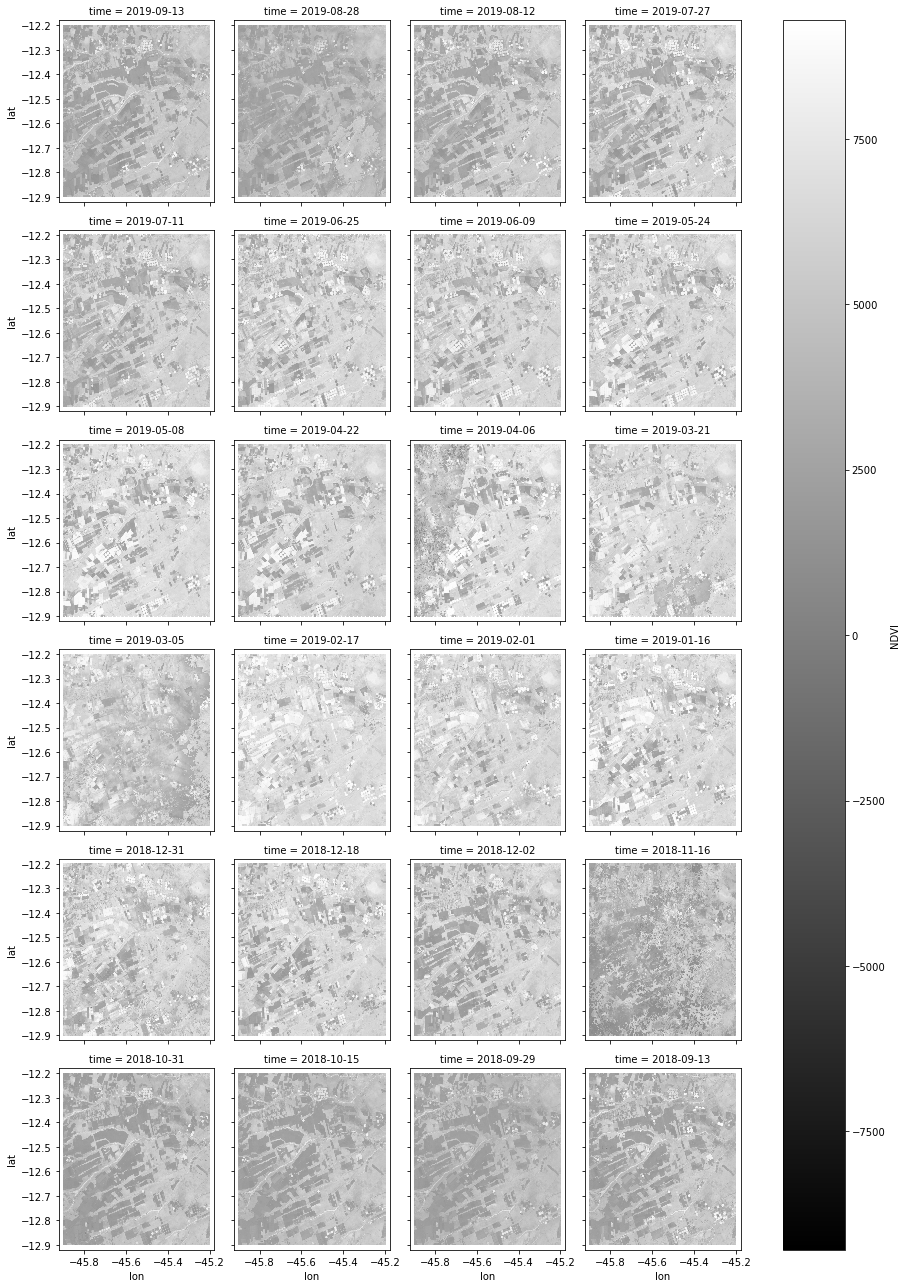

In [6]:
xarray.NDVI.plot(x="lon", y="lat", col="time", col_wrap=4, cmap='gray')

Now lets select some sample points to be used in our examples.

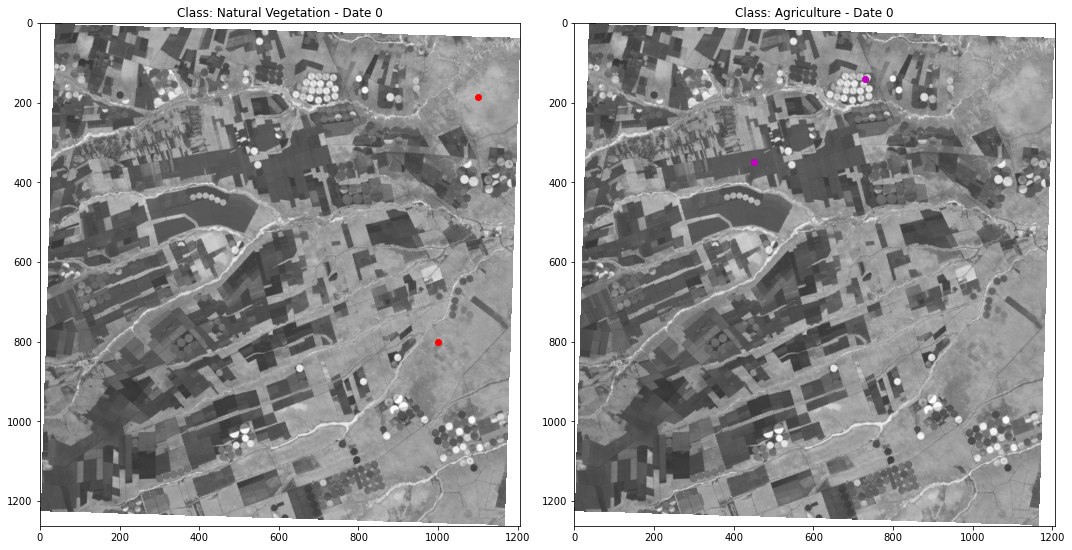

In [7]:
img = numpy.squeeze(xarray.NDVI.values)
fig= plt.figure(figsize=(15, 15))  # width, height in inches
sub = fig.add_subplot(1, 2, 1)
sub.imshow(img[0,:,:], cmap = 'gray')
plt.scatter(1100,185,color='r')
plt.scatter(1000,800,color='r')
plt.title('Class: Natural Vegetation - Date 0')
sub = fig.add_subplot(1, 2, 2)
sub.imshow(img[0,:,:], cmap = 'gray')
plt.scatter(450,350,color='m')
plt.scatter(730,140,color='m')
plt.title('Class: Agriculture - Date 0')
plt.tight_layout()

Time Series extraction
---------------------

Now let's use our "samples" to extract some time series profiles.

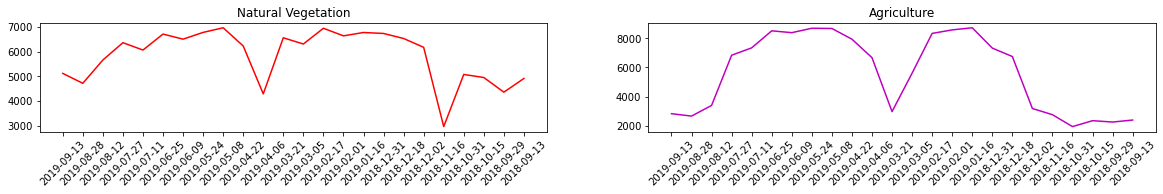

In [8]:
import matplotlib.dates as mdates

fn = img[:,1100,185] #Natural vegetation
agr = img[:,450,350] #Agriculture pattern

#get dates from xarray
dates = xarray.time.values

fig, ax = plt.subplots(1,2, figsize=(20,2))
ax[0].plot(dates,fn,color = 'r')
ax[0].title.set_text('Natural Vegetation')
ax[0].set_xticklabels(dates, rotation=45)

ax[1].plot(dates,agr, color = 'm')
ax[1].title.set_text('Agriculture')
ax[1].set_xticklabels(dates, rotation=45);

Polar plot
---------------------

The stmetrics is currently composed by 4 modules:

*   Metrics - With some functions to compute the all metrics available
*   Basics  - That has the implementation of the basics metrics
*   Polar   - That has the implementation of the polar metrics proposed by Körting (2013).
*   Fractal - That has the implementatio of fractal metrics that are currently under assessment.


The polar approach proposed by Körting (2013) convert the time series to a polar coordinate system. This way we can plot the series in this space just to look at it and get some insights about the time series. For this, we can use the funtion `polar_plot`. 

The plot as you will see is composed by the series over four quadrants. The idea here is observe a stronger response over a specific period. Imagine that your time series encompass a year of observations, this way each quadrant represents 3 months.

![Polar plot representation.](https://drive.google.com/uc?export=view&id=1IFFXSFtNNZJ4L_ihfnRgBTD6jRf4puoD)


> Reference: Körting, Thales & Câmara, Gilberto & Fonseca, Leila. (2013).Land Cover Detection Using Temporal Features Based On Polar Representation.





Natural Vegetation


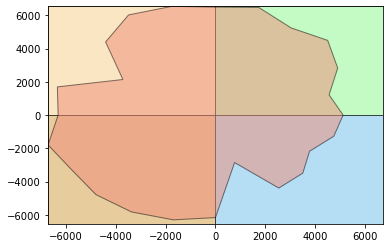

Agriculture


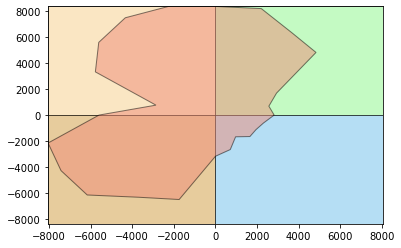

In [9]:
#Plotting our time series samples
#Natural Vegetation
print('Natural Vegetation')
stmetrics.polar.polar_plot(fn)

print('Agriculture')
#Pasture
stmetrics.polar.polar_plot(agr)

Metrics computation
---------------------

The stmetrics has two functions to compute the metrics. The `get_metrics` function was designed to be used for compute the metrics of one time series. Along with the metrics, using the function you can also see the polar plot. Just remember, one series each time.

The `sits2metrics` function was developed to compute the metrics over images, as the name states. For this function we use multiprocessing package to improve perfomance. Don't worry if it is using the whole campacity of your system, it was designed to do it. 

------

> **_NOTE:_** This process may take sometime, tha package is computing **28 metrics!**



In [10]:
im_metrics = stmetrics.metrics.sits2metrics(xarray)

In [13]:
im_metrics

<xarray.Dataset>
Dimensions:       (band: 1, metric: 28, time: 24, x: 1207, y: 1263)
Coordinates:
  * band          (band) int32 1
  * y             (y) float64 9.965e+06 9.965e+06 ... 9.884e+06 9.884e+06
  * x             (x) float64 5.866e+06 5.866e+06 ... 5.943e+06 5.943e+06
  * time          (time) object '2019-09-13' '2019-08-28' ... '2018-09-13'
    lon           (y, x) float64 -45.92 -45.92 -45.92 ... -45.18 -45.18 -45.18
    lat           (y, x) float64 -12.2 -12.2 -12.2 -12.2 ... -12.9 -12.9 -12.9
  * metric        (metric) object 'max_ts' 'min_ts' ... 'hurst_exp' 'katz_fd'
Data variables:
    NDVI          (time, band, y, x) float64 nan nan nan nan ... nan nan nan nan
    NDVI_metrics  (metric, y, x) float64 nan nan nan nan nan ... nan nan nan nan

Image Metrics
---------------------

The output of `get_metrics` and `sits2metrics` follows the same order and can be acessed with the `list_metrics` function that is available at `utils` module.

In [11]:
stmetrics.utils.list_metrics()

['max_ts',
 'min_ts',
 'mean_ts',
 'std_ts',
 'sum_ts',
 'amplitude_ts',
 'mse_ts',
 'fslope_ts',
 'skew_ts',
 'amd_ts',
 'abs_sum_ts',
 'iqr_ts',
 'fqr_ts',
 'tqr_ts',
 'sqr_ts',
 'ecc_metric',
 'gyration_radius',
 'area_ts',
 'polar_balance',
 'angle',
 'area_q1',
 'area_q2',
 'area_q3',
 'area_q4',
 'csi',
 'dfa_fd',
 'hurst_exp',
 'katz_fd']

Now let's plot the results!
---------------------

Don't worry if some metric is too noise or you don't see a clear pattern, some features are not always representative.

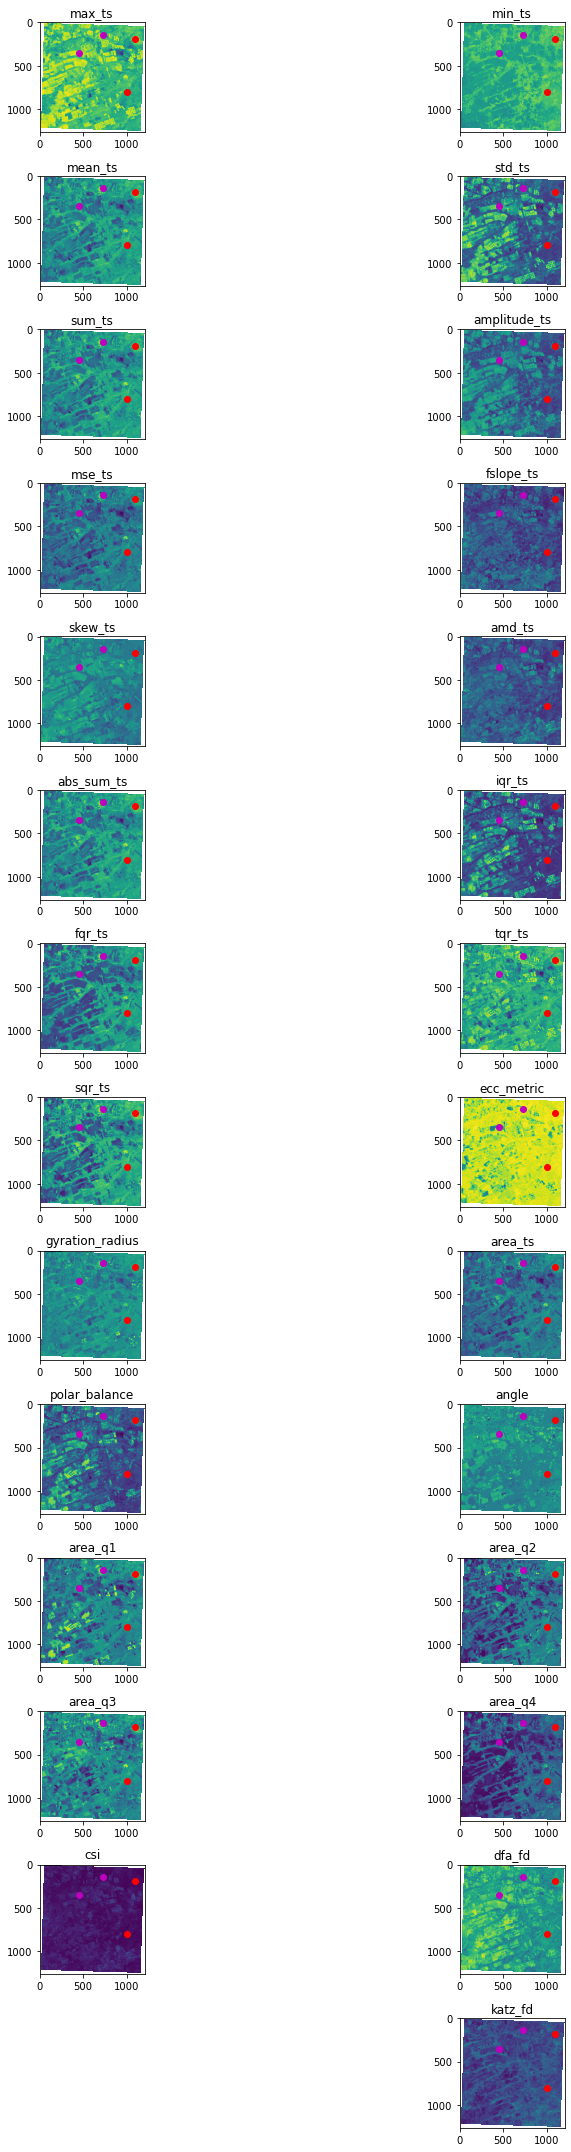

In [19]:
header = stmetrics.utils.list_metrics()

img = im_metrics.NDVI_metrics.values

plt.figure(1,figsize=(15,30))

for b,n in zip(range(1, img.shape[0]+1),header):
    plt.subplot(14,2,b,)
    plt.imshow(img[b-1,:,:])
    plt.scatter(1100,185,color='r')
    plt.scatter(1000,800,color='r')
    plt.scatter(450,350,color='m')
    plt.scatter(730,140,color='m')
    plt.tight_layout()
    plt.title(n)

plt.show()

That's all!
---------------------

Soon we will have more examples and usages to perform time series classifications.

Keep watching our repo on github https://github.com/brazil-data-cube/stmetrics and our documentation https://stmetrics.readthedocs.io/en/latest/! 

If you find any problems in the package, please, submit an issue on github. 

**Thanks for checking!**